In [3]:
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier
from tqdm import tqdm

import logging
log_fmt = "[%(asctime)s] %(levelname)s: %(message)s"
logging.basicConfig(format=log_fmt, level=logging.INFO)
import warnings
warnings.filterwarnings('ignore')

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"


import gzip
import pickle
base_path = '/home/zengrui/datasets/190829_Kanshan_zjfx'

def save_param(param, param_name):
    with open(f'{base_path}/temp/{param_name}.txt', 'wb') as f:
        pickle.dump(param, f)
        
def read_param(param_name):
    with open(f'{base_path}/temp/{param_name}.txt', 'rb') as f:
        return pickle.load(f)

def gload(file_name):
    with gzip.GzipFile(f'{base_path}/temp/{file_name}.gzip', 'rb') as f:
        return pickle.load(f)

def gdump(obj, file_name):
    with gzip.GzipFile(f'{base_path}/temp/{file_name}.gzip', 'wb') as f:
        pickle.dump(obj, f)
        
def extract_day(s):
    return s.apply(lambda x: int(x.split('-')[0][1:]))

def extract_hour(s):
    return s.apply(lambda x: int(x.split('-')[1][1:]))

# Data analyze

In [4]:
# Data Processing
import numpy as np
import pandas as pd

# Basic Visualization tools
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
sns.set_palette('husl')


# Bokeh (interactive visualization)
from bokeh.io import show, output_notebook
from bokeh.palettes import Spectral9
from bokeh.plotting import figure
# output_notebook() # You can use output_file()

# Special Visualization
from wordcloud import WordCloud # wordcloud
import missingno as msno # check missing value

In [5]:
X_train_all = read_param('X_train_all')
X_train_all.describe()

,freq,gender,hour,q_ans_count,q_diff_qa_days_count,q_diff_qa_days_max,q_diff_qa_days_mean,q_diff_qa_days_min,q_diff_qa_days_std,q_diff_qa_days_sum,...,uid_enc_count,qid_enc_count,gender_count,freq_count,uf_c1_count,uf_c2_count,uf_c3_count,uf_c4_count,uf_c5_count,wk
count,2.593669e+06,2.593669e+06,2.593669e+06,490027.000000,490027.000000,490027.000000,490027.000000,490027.000000,443028.000000,4.900270e+05,...,2.593669e+06,2.593669e+06,2.593669e+06,2.593669e+06,2.593669e+06,2.593669e+06,2.593669e+06,2.593669e+06,2.593669e+06,2.593669e+06
mean,2.871552e+00,2.190013e+00,1.367825e+01,46.319027,46.319027,40.922741,36.111130,30.572540,3.878316,1.282072e+03,...,6.826989e-02,2.574055e-02,4.631898e-01,8.169875e-01,5.195430e-01,6.060912e-01,4.346154e-01,4.142986e-01,8.911068e-01,2.980610e+00
std,1.823289e+00,8.339975e-01,5.834045e+00,139.550949,139.550949,197.674866,196.608109,195.283691,3.206081,1.256404e+04,...,2.521715e-01,1.568476e-01,4.962970e-01,3.243539e-01,4.904770e-01,4.142540e-01,2.670735e-01,4.646967e-01,3.115053e-01,2.016057e+00
min,1.000000e+00,1.000000e+00,0.000000e+00,1.000000,1.000000,-10.000000,-14.200000,-18.000000,0.000000,-7.100000e+01,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,1.000000e+00,9.000000e+00,4.000000,4.000000,3.000000,1.666667,0.000000,1.414214,7.000000e+00,...,3.601916e-06,5.403069e-05,0.000000e+00,9.605711e-01,9.446329e-03,1.362257e-01,2.183076e-01,1.213438e-02,1.000000e+00,1.000000e+00
50%,2.000000e+00,2.000000e+00,1.300000e+01,8.000000,8.000000,10.000000,5.000000,0.000000,3.331666,4.900000e+01,...,1.080575e-05,1.260716e-04,8.695241e-03,9.605711e-01,1.000000e+00,1.000000e+00,4.386485e-01,6.927558e-02,1.000000e+00,3.000000e+00
75%,5.000000e+00,3.000000e+00,1.800000e+01,28.000000,28.000000,19.000000,10.333333,1.000000,5.598169,2.580000e+02,...,3.601916e-05,3.602046e-04,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,6.125873e-01,1.000000e+00,1.000000e+00,5.000000e+00
max,5.000000e+00,3.000000e+00,2.300000e+01,2541.000000,2541.000000,3086.000000,3080.000000,3073.000000,33.941124,3.410922e+06,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,6.000000e+00


In [6]:
y_train_all = gload('y_train_all')
data = pd.concat([X_train_all, y_train_all], axis=1)

In [33]:
Counter(data['gender'])

Counter({3: 1195253, 2: 695994, 1: 702422})

In [32]:
data[['gender', 'gender_count']]

,gender,gender_count
0,3,1.000000
1,3,1.000000
2,3,1.000000
3,2,0.000000
4,1,0.008695
...,...,...
2593664,1,0.008695
2593665,3,1.000000
2593666,3,1.000000
2593667,2,0.000000


In [34]:
data['q_diff_qa_days_mean']

0                 NaN
1                 NaN
2            9.531250
3          222.333328
4                 NaN
              ...    
2593664           NaN
2593665           NaN
2593666           NaN
2593667           NaN
2593668           NaN
Name: q_diff_qa_days_mean, Length: 2593669, dtype: float32

In [5]:
list(data.columns)

['freq',
 'gender',
 'hour',
 'q_ans_count',
 'q_diff_qa_days_count',
 'q_diff_qa_days_max',
 'q_diff_qa_days_mean',
 'q_diff_qa_days_min',
 'q_diff_qa_days_std',
 'q_diff_qa_days_sum',
 'q_has_img_count',
 'q_has_img_max',
 'q_has_img_mean',
 'q_has_img_min',
 'q_has_img_std',
 'q_has_img_sum',
 'q_has_video_count',
 'q_has_video_max',
 'q_has_video_mean',
 'q_has_video_min',
 'q_has_video_std',
 'q_has_video_sum',
 'q_inv_count',
 'q_inv_max',
 'q_inv_mean',
 'q_inv_min',
 'q_inv_std',
 'q_inv_sum',
 'q_is_dest_count',
 'q_is_dest_max',
 'q_is_dest_mean',
 'q_is_dest_min',
 'q_is_dest_std',
 'q_is_dest_sum',
 'q_is_good_count',
 'q_is_good_max',
 'q_is_good_mean',
 'q_is_good_min',
 'q_is_good_std',
 'q_is_good_sum',
 'q_is_rec_count',
 'q_is_rec_max',
 'q_is_rec_mean',
 'q_is_rec_min',
 'q_is_rec_std',
 'q_is_rec_sum',
 'q_reci_cheer_count',
 'q_reci_cheer_max',
 'q_reci_cheer_mean',
 'q_reci_cheer_min',
 'q_reci_cheer_std',
 'q_reci_cheer_sum',
 'q_reci_comment_count',
 'q_reci_com

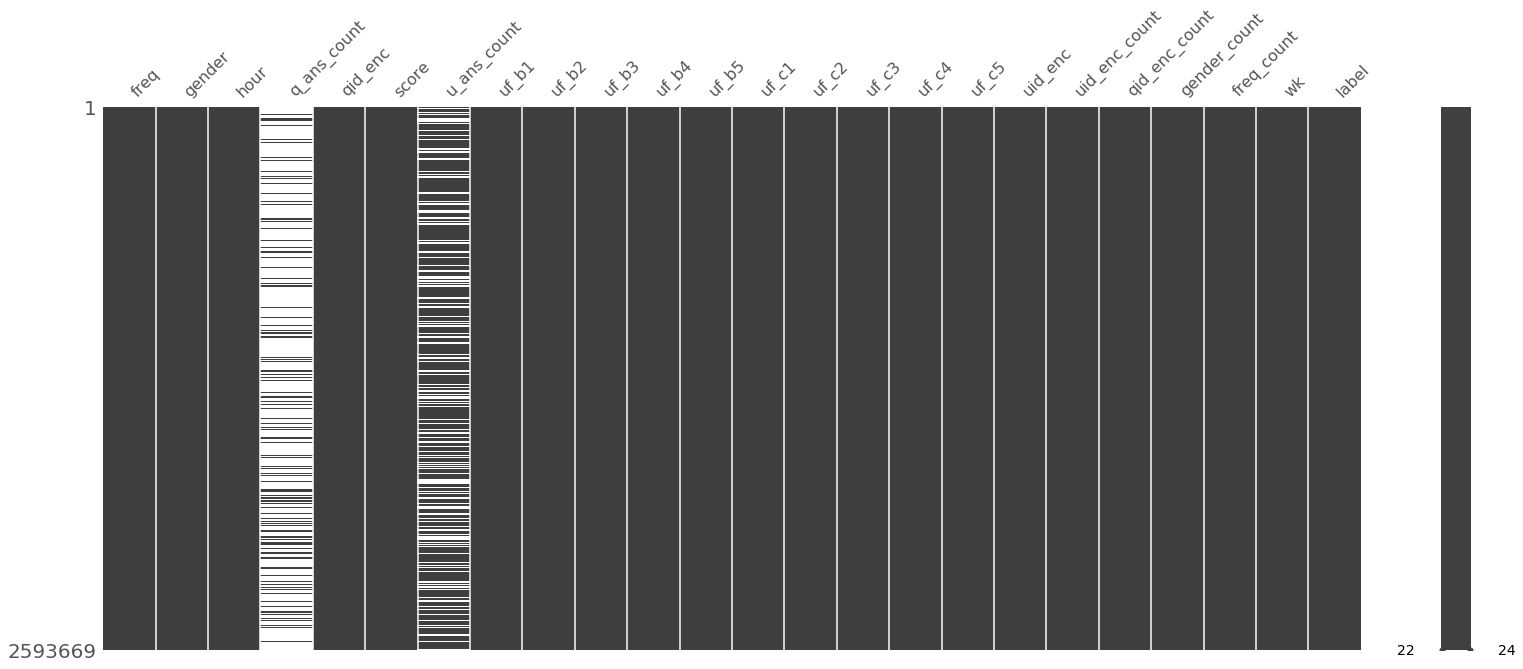

In [10]:
msno.matrix(data[['freq', 'gender', 'hour', 'q_ans_count', 'qid_enc', 'score', 'u_ans_count', 'uf_b1', 'uf_b2', 'uf_b3',
                  'uf_b4', 'uf_b5', 'uf_c1', 'uf_c2', 'uf_c3', 'uf_c4', 'uf_c5', 'uid_enc', 'uid_enc_count', 'qid_enc_count',
                  'gender_count', 'freq_count', 'wk', 'label']])

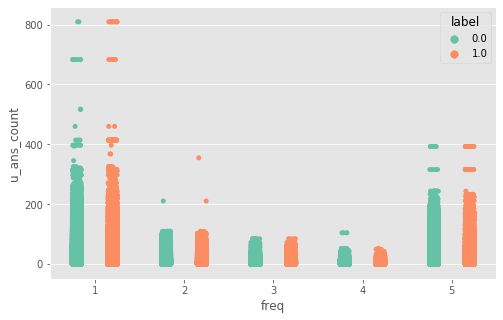

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
# sns.boxplot(x='label', y='u_word_count_mean', data=data, ax=ax)
sns.stripplot(x="freq", y="u_ans_count", hue="label", data=data, jitter=True,palette="Set2", split=True, ax=ax)
plt.show()

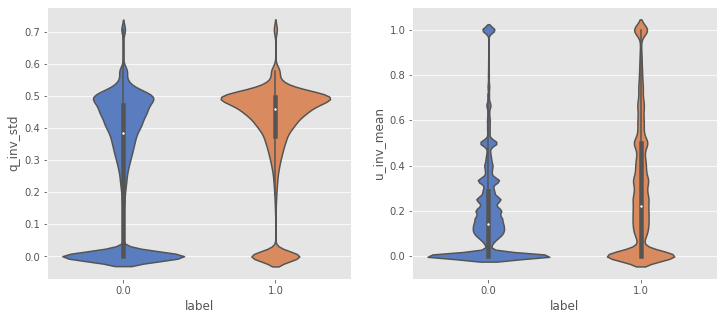

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
sns.violinplot(x="label", y="q_inv_std", data=data, palette="muted", ax=ax1)
sns.violinplot(x="label", y="u_inv_mean", data=data, palette="muted", ax=ax2)
# sns.stripplot(x='label', y='q_ans_count', data=data, size=0.1, jitter=True, palette='Set2', split=True, ax=ax1)
# sns.stripplot(x='label', y='u_ans_count', data=data, size=0.1, jitter=True, palette='Set2', split=True, ax=ax2)
plt.show()

In [13]:
tmp = data[:100000]
relative_cols = []
for i in tmp.columns:
    corr = tmp['label'].corr(tmp[i])
    if abs(corr) >= 0.1:
        relative_cols.append(i)
        print(i, corr)

q_inv_max 0.18551650649690396
q_inv_mean 0.18088071443832018
q_inv_std 0.19757040586944907
u_ans_count 0.12809451824781948
u_diff_qa_days_count 0.12809451824781948
u_has_img_count 0.12809451824781948
u_has_video_count 0.12809451824781948
u_inv_mean 0.1373815293701803
u_inv_sum 0.1677027012149863
u_is_dest_count 0.12809451824781948
u_is_good_count 0.12809451824781948
u_is_rec_count 0.12809451824781948
u_reci_cheer_count 0.12809451824781948
u_reci_comment_count 0.12809451824781948
u_reci_dis_count 0.12809451824781948
u_reci_mark_count 0.12809451824781948
u_reci_no_help_count 0.12809451824781948
u_reci_tks_count 0.12809451824781948
u_reci_uncheer_count 0.12809451824781948
u_reci_xxx_count 0.12809451824781948
u_word_count_count 0.12809451824781948
qid_enc_count 0.11457718692489414
label 1.0


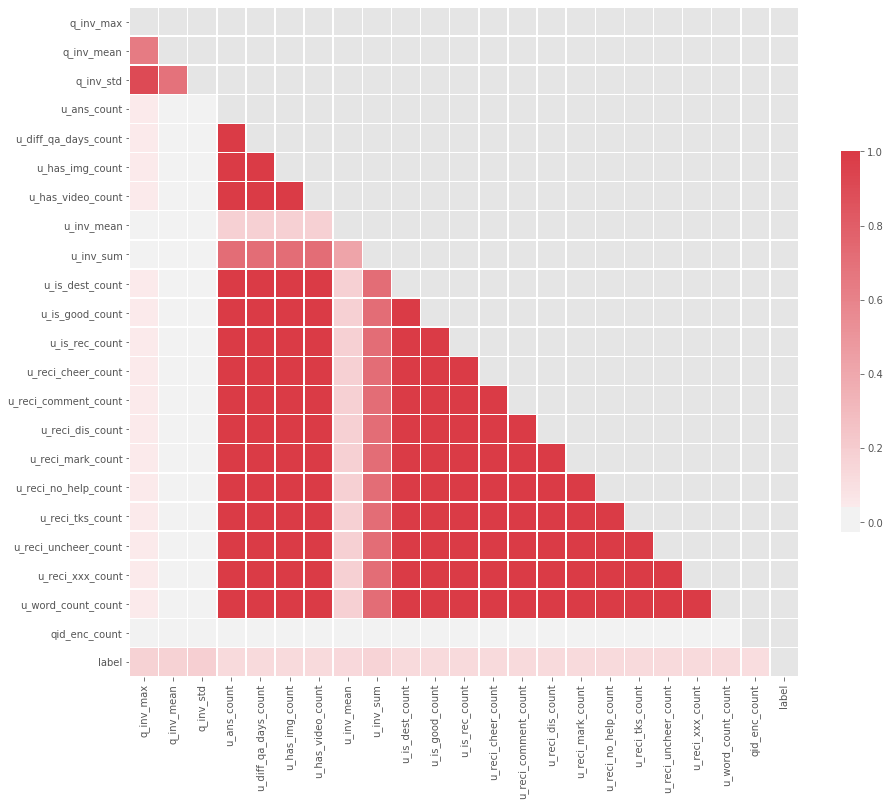

In [14]:
corr = data[relative_cols].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(15, 14))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [18]:
from collections import Counter
Counter(data['uf_c1_count'])

Counter({0.02211448922753334: 29098,
         0.02445071190595627: 32314,
         0.006221342366188765: 8298,
         0.005738855805248022: 7531,
         0.007061752025038004: 9393,
         1.0: 1323082,
         0.010599985718727112: 13970,
         0.031101983040571213: 40906,
         0.0069145881570875645: 9066,
         0.0009938800940290093: 1290,
         0.005517585203051567: 7227,
         0.014566046185791492: 19296,
         0.0012230349238961935: 1599,
         0.054193008691072464: 71581,
         0.023452626541256905: 31181,
         0.008645338006317616: 11453,
         0.0002606898488011211: 693,
         0.009209815412759781: 12126,
         0.000601268548052758: 803,
         0.002255282597616315: 2988,
         3.784207729040645e-05: 100,
         0.00944632850587368: 12359,
         0.0036507092881947756: 4846,
         0.0030173801351338625: 3971,
         0.0008976981625892222: 1203,
         0.00044832349522039294: 596,
         0.00019867089577019215: 529,
 

In [19]:
data['uf_c1_count']

0          0.022114
1          0.024451
2          0.006221
3          0.024451
4          0.005739
             ...   
2593664    1.000000
2593665    1.000000
2593666    1.000000
2593667    0.007786
2593668    0.007786
Name: uf_c1_count, Length: 2593669, dtype: float32